# B3. TEST THE CNN MODEL ON REAL IMAGES
### Code to Test on Unseen Test Images Collected from accident locations in WA

### Importing libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from matplotlib.image import imread
import seaborn as sns
import random
from PIL import Image
import cv2 

from sklearn.model_selection import  train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

import keras
from tensorflow.keras.models import Sequential
from keras import models, layers, optimizers
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model
from keras.models import Model

In [2]:
from skimage.io import imread
from skimage.transform import resize
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))


Num GPUs Available:  0


### Utility Functions - For preprocessing

In [4]:
# show class meta. takes class label as a number (0 to 43) and plts the meta image for the specific class
# using
def show_class_meta(class_num):
    plt.figure(figsize=(2,2))
    path = "../data/final_sign_images/Meta/" #Not able to push data to git, give local file path
    # no alternate path in git dir just dont run
    link_to_image = str(path + str(class_num) + '.png')
    class_img = imread(link_to_image)
    plt.imshow(class_img)
    plt.xlabel(class_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(class_img.shape[0], fontsize = 10)#height of image
    plt.title("Class: " + str(class_num))
    

In [5]:
# Show image and prediction from df of prediction
def show_prediction(pred_data,row_id,path_to_image="./final_WWashington_data_images/EU_Google_street_images/"):
    
    
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(15,5)
    file_name = pred_data.loc[row_id,'Image_Path']
    img_path = path_to_image +file_name
    img = Image.open(img_path)
    true_class=pred_data.loc[row_id,'ClassId']
    pred_class=pred_data.loc[row_id,'Pred_Class']
    ax[0].imshow(img)
    ax[0].set_title("Original Image")


    meta_path = "../data/final_sign_images/Meta/" #Not able to push data to git, give local file path
    link_to_true = str(meta_path + str(true_class) + '.png')
    link_to_pred = str(meta_path + str(pred_class) + '.png')
    true_img = imread(link_to_true)
    pred_img = imread(link_to_pred)
    ax[1].imshow(true_img)
    ax[1].set_title("True Class")
    ax[2].imshow(pred_img)
    ax[2].set_title("Model Predicted class")

In [6]:
# Data sets summary
# not really needed
def info_dataset(X_train, X_valid, y_train):
    # Number of training examples
    n_train = X_train.shape[0]

    # Number of validation examples
    n_validation = X_valid.shape[0]

    # Shape of an traffic sign image
    image_shape = X_train[0].shape

    # Unique classes/labels in the dataset.
    n_classes = max(y_train)+1

    print("Number of training examples =", n_train)
    print("Number of validation examples =", n_validation)
    print("Image data shape =", image_shape)
    print("Number of classes =", n_classes)

In [7]:
# Convert images to grayscale
# might delete
def RGB2GREY(data_RGB):
    
    n_data=data_RGB.shape[0]
    data_gr=np.zeros((n_data,32,32,1))
    for i in range(n_data):
        tmp = cv2.cvtColor(data_RGB[i], cv2.COLOR_RGB2GRAY)
        data_gr[i]= np.reshape(tmp,(32,32,1))
    
    return data_gr

In [8]:
#Normalisation of data if need 
def norm_data(data_gr):
    
    return (data_gr-128)/128

### Utility Functions - For plotting the Confusion Matrix

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 1. Load the Best Saved Model

In [10]:
my_model=models.load_model('./model_store/final_model.h5')

In [11]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

### 2. Load Test Data from Dataset

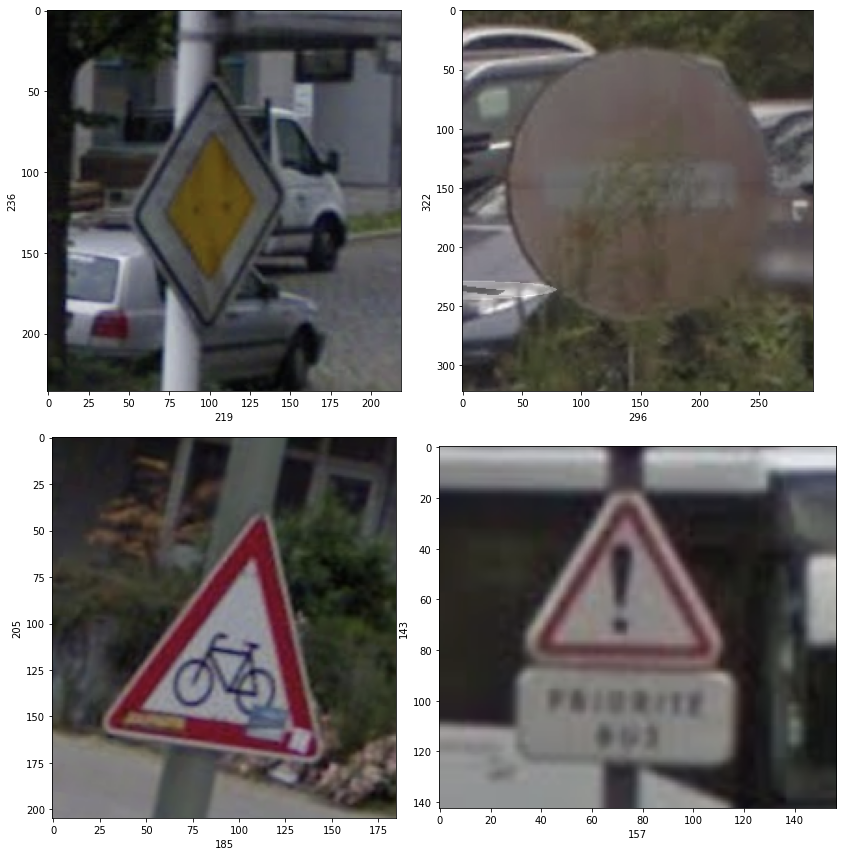

In [12]:
# just a quick explore to see some of the test images collected from steetview in France
plt.figure(figsize=(12,12))
path = "./final_WWashington_data_images/EU_Google_street_images/" #Not able to push data to git, give local file path

for i in range(1,5):
    plt.subplot(2,2,i)
    plt.tight_layout()
    rand_img = imread(path + random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

In [13]:
# load Test.csv for true label
real_eu_df = pd.read_csv("./final_WWashington_data_images/eu_signs.csv")
real_eu_df.head()

,Country,Link,ClassId
0,FR,001.png,35
1,FR,002.png,2
2,FR,003.png,17
3,FR,004.png,17
4,FR,005.png,22


In [14]:
real_eu_df.tail()

,Country,Link,ClassId
44,DE,045.png,17
45,DE,046.png,17
46,DE,047.png,1
47,DE,048.png,18
48,DE,049.png,36


In [15]:
real_eu_df.shape

(49, 3)

In [16]:
# create a dataframe that will store the predicted classes
pred_eu_df = pd.DataFrame(columns=['Image_Path','ClassId','Pred_Class'])
pred_eu_df

,Image_Path,ClassId,Pred_Class


In [17]:
start_path ="./final_WWashington_data_images/EU_Google_street_images/"

for row in real_eu_df.values:
    img_path = start_path + row[1]
    print(img_path)
    img = Image.open(img_path)
    img = img.resize((50,50))
    img = np.array(img)
    
    # convert from 4 channels in png to 3 channels
    if len(img.shape) > 2 and img.shape[2] == 4:
        #convert the image from RGBA2RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    
    
    img = np.expand_dims(img, axis=0)
    
    pred = np.argmax(my_model.predict(img), axis=-1)
    #pred= -1
    print(pred[0])
    
    # appends a new row to the pred_df storind the true and predicted class
    pred_eu_df = pred_eu_df.append({'Image_Path':row[1],'ClassId': row[2], 'Pred_Class':pred[0]}, ignore_index=True)


./final_WWashington_data_images/EU_Google_street_images/001.png
34
./final_WWashington_data_images/EU_Google_street_images/002.png
2
./final_WWashington_data_images/EU_Google_street_images/003.png
12
./final_WWashington_data_images/EU_Google_street_images/004.png
17
./final_WWashington_data_images/EU_Google_street_images/005.png
22
./final_WWashington_data_images/EU_Google_street_images/006.png
13
./final_WWashington_data_images/EU_Google_street_images/007.png
24
./final_WWashington_data_images/EU_Google_street_images/008.png
1
./final_WWashington_data_images/EU_Google_street_images/009.png
22
./final_WWashington_data_images/EU_Google_street_images/010.png
41
./final_WWashington_data_images/EU_Google_street_images/011.png
11
./final_WWashington_data_images/EU_Google_street_images/012.png
34
./final_WWashington_data_images/EU_Google_street_images/013.png
13
./final_WWashington_data_images/EU_Google_street_images/014.png
12
./final_WWashington_data_images/EU_Google_street_images/015.png


In [18]:
pred_eu_df.tail()

,Image_Path,ClassId,Pred_Class
44,045.png,17,25
45,046.png,17,17
46,047.png,1,20
47,048.png,18,18
48,049.png,36,36


In [19]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix

# setup the class_labels
class_label = list(range(0,43))

In [20]:
y_true = list(pred_eu_df['ClassId'])
y_pred = list(pred_eu_df['Pred_Class'])
confusion_matrix(y_true, y_pred)

array([[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0],
       [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 

In [21]:
pred_eu_df['Right']=False
pred_eu_df.loc[pred_eu_df['ClassId']==pred_eu_df['Pred_Class'],'Right'] = True 
pred_eu_df

,Image_Path,ClassId,Pred_Class,Right
0,001.png,35,34,False
1,002.png,2,2,True
2,003.png,17,12,False
3,004.png,17,17,True
4,005.png,22,22,True
5,006.png,14,13,False
6,007.png,27,24,False
7,008.png,0,1,False
8,009.png,22,22,True
9,010.png,18,41,False


In [22]:
pred_eu_df['Right'].value_counts()

False    27
True     22
Name: Right, dtype: int64

In [23]:
pred_eu_df['Right'].value_counts()/pred_eu_df.shape[0]

False    0.55102
True     0.44898
Name: Right, dtype: float64

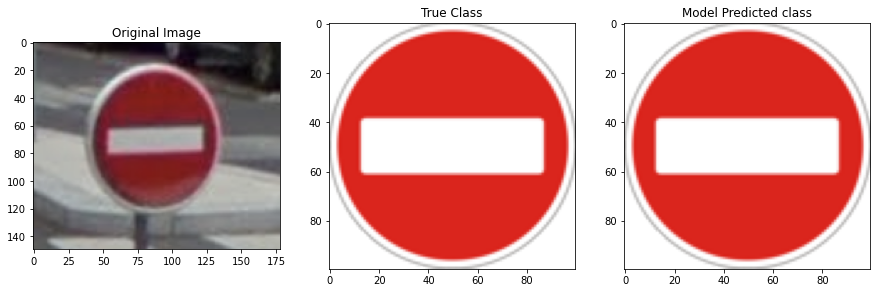

In [24]:
show_prediction(pred_eu_df,3)

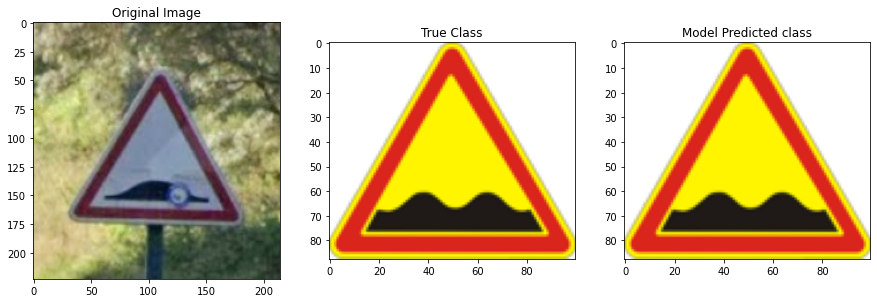

In [25]:
show_prediction(pred_eu_df,4)

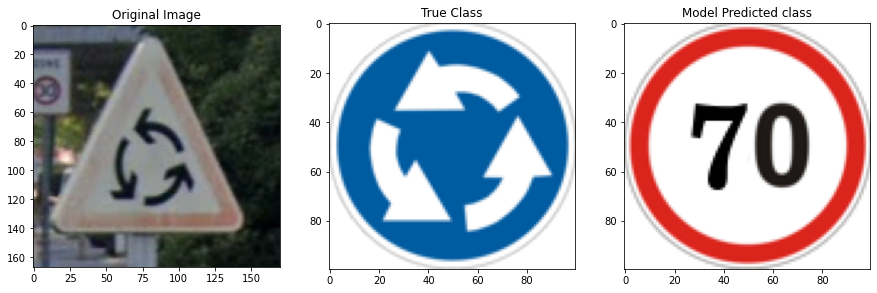

In [26]:
show_prediction(pred_eu_df,17)

### Washington Dataset of real images  

##### Images that we collected manually are stored in folder  images_from_from_streetview

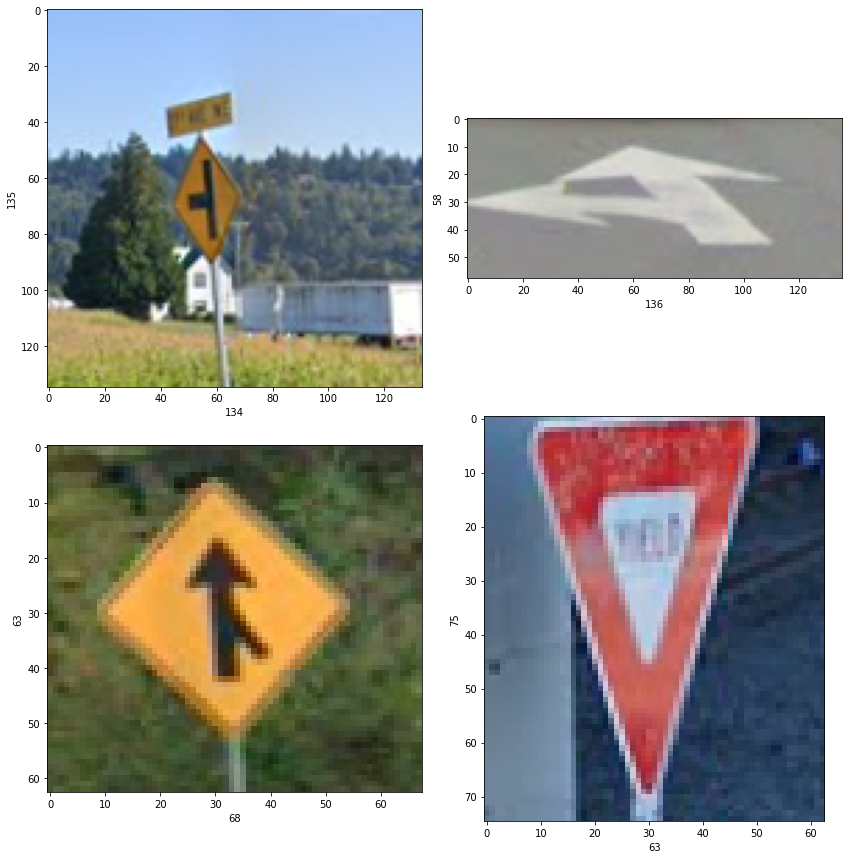

In [39]:
# just a quick explore to see some of the test images
plt.figure(figsize=(12,12))
path = "./final_WWashington_data_images/images_from_from_streetview/" #Not able to push data to git, give local file path

for i in range(1,5):
    plt.subplot(2,2,i)
    plt.tight_layout()
    rand_img = imread(path + random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

### Reading csv file that we made using real image data. File is named as Washington_sign_images_final.csv

In [66]:
# load Test.csv for true label
real_wa_df = pd.read_csv("./final_WWashington_data_images/Washington_sign_images_final.csv")
real_wa_df = real_wa_df.drop("Unnamed: 0",axis=1)
real_wa_df.head()

,Number,data_frame_row_number,Accident Id,Image_link,class_type
0,1,2,A-2827637,0001.png,37
1,2,2,A-2827637,0002.png,14
2,3,2,A-2827637,0003.png,27
3,4,2,A-2827637,0005.png,14
4,5,2,A-2827637,0007.png,14


In [67]:
real_wa_df

,Number,data_frame_row_number,Accident Id,Image_link,class_type
0,1,2,A-2827637,0001.png,37
1,2,2,A-2827637,0002.png,14
2,3,2,A-2827637,0003.png,27
3,4,2,A-2827637,0005.png,14
4,5,2,A-2827637,0007.png,14
5,6,2,A-2827637,0008.png,14
6,7,2,A-2827637,0009.png,27
7,8,3,A-2827704,0013.png,14
8,9,3,A-2827704,0014.png,27
9,10,3,A-2827704,0015.png,13


In [68]:
real_wa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Number                 49 non-null     int64 
 1   data_frame_row_number  49 non-null     int64 
 2   Accident Id            49 non-null     object
 3   Image_link             49 non-null     object
 4   class_type             49 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 2.0+ KB


In [69]:
# create a dataframe that will store the predicted classes
pred_wa_df = pd.DataFrame(columns=['Image_Path','ClassId','Pred_Class'])
pred_wa_df

,Image_Path,ClassId,Pred_Class


In [70]:
start_path ="./final_WWashington_data_images/images_from_from_streetview/"

for row in real_wa_df.values:
    img_path = start_path + row[3]
    print(img_path)
    img = Image.open(img_path)
    img = img.resize((50,50))
    img = np.array(img)
    
    # convert from 4 channels in png to 3 channels
    if len(img.shape) > 2 and img.shape[2] == 4:
        #convert the image from RGBA2RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    
    
    img = np.expand_dims(img, axis=0)
    
    pred = np.argmax(my_model.predict(img), axis=-1)
    #pred= -1
    print(pred[0])
    
    # appends a new row to the pred_df storind the true and predicted class
    pred_wa_df = pred_wa_df.append({'Image_Path':row[3],'ClassId': row[4], 'Pred_Class':pred[0]}, ignore_index=True)
        


./final_WWashington_data_images/images_from_from_streetview/0001.png
12
./final_WWashington_data_images/images_from_from_streetview/0002.png
12
./final_WWashington_data_images/images_from_from_streetview/0003.png
12
./final_WWashington_data_images/images_from_from_streetview/0005.png
17
./final_WWashington_data_images/images_from_from_streetview/0007.png
14
./final_WWashington_data_images/images_from_from_streetview/0008.png
12
./final_WWashington_data_images/images_from_from_streetview/0009.png
17
./final_WWashington_data_images/images_from_from_streetview/0013.png
14
./final_WWashington_data_images/images_from_from_streetview/0014.png
1
./final_WWashington_data_images/images_from_from_streetview/0015.png
13
./final_WWashington_data_images/images_from_from_streetview/0016.png
40
./final_WWashington_data_images/images_from_from_streetview/0017.png
38
./final_WWashington_data_images/images_from_from_streetview/0018.png
28
./final_WWashington_data_images/images_from_from_streetview/0019.

In [71]:
pred_wa_df.head()

,Image_Path,ClassId,Pred_Class
0,0001.png,37,12
1,0002.png,14,12
2,0003.png,27,12
3,0005.png,14,17
4,0007.png,14,14


In [72]:
pred_wa_df.shape

(49, 3)

In [73]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix

# setup the class_labels
class_label = list(range(0,43))

In [74]:
y_true = list(pred_wa_df['ClassId'])
y_pred = list(pred_wa_df['Pred_Class'])
confusion_matrix(y_true, y_pred)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 1, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 

In [75]:
pred_wa_df['Right']=False
pred_wa_df.loc[pred_wa_df['ClassId']==pred_wa_df['Pred_Class'],'Right'] = True 
pred_wa_df

,Image_Path,ClassId,Pred_Class,Right
0,0001.png,37,12,False
1,0002.png,14,12,False
2,0003.png,27,12,False
3,0005.png,14,17,False
4,0007.png,14,14,True
5,0008.png,14,12,False
6,0009.png,27,17,False
7,0013.png,14,14,True
8,0014.png,27,1,False
9,0015.png,13,13,True


In [76]:
pred_wa_df['Right'].value_counts()

False    42
True      7
Name: Right, dtype: int64

In [77]:
pred_wa_df['Right'].value_counts()/pred_wa_df.shape[0]

False    0.857143
True     0.142857
Name: Right, dtype: float64

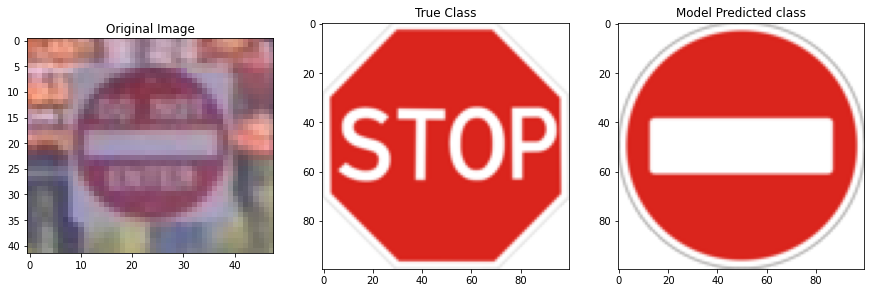

In [78]:
show_prediction(pred_wa_df,3,path_to_image="./final_WWashington_data_images/images_from_from_streetview/")

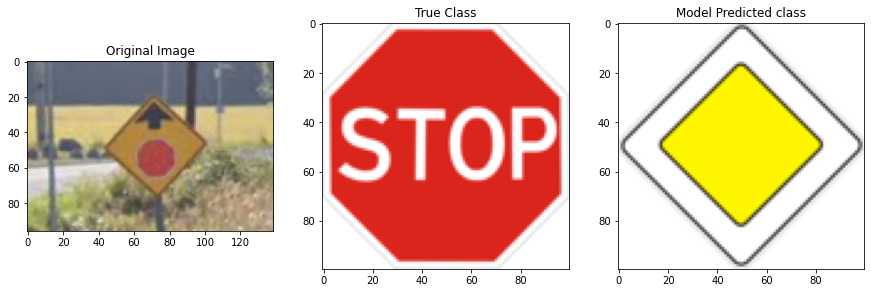

In [80]:
show_prediction(pred_wa_df,1,path_to_image="./final_WWashington_data_images/images_from_from_streetview/")

In [ ]:
show_prediction(pred_wa_df,1,path_to_image="./final_WWashington_data_images/images_from_from_streetview/")